# [DACON] 건설기계 오일 상태 분류 AI 경진대회
### 배경
- 건설기계 분야의 데이터를 분석, 활용하는 방안 제시
- 건설 장비 산업의 지능화에 대한 연구활동 홍보 및 우수 인재 발굴

### 주제
- 건설장비에서 작동 오일의 상태를 실시간으로 모니터링하기 위한 **오일 상태 판단 모델 개발**
- 적절한 교체 주기를 파악하고자 함

### 평가방식
- Macro F1 Score

### Library

In [16]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import xgboost as xgb
import lightgbm as lgbm
import catboost

### Data Load

In [2]:
main_path = "./data"

train_df = pd.read_csv(os.path.join(main_path, "train.csv"))
test_df = pd.read_csv(os.path.join(main_path, "test.csv"))

train_df.shape, test_df.shape

((14095, 54), (6041, 19))

In [3]:
# 실제 진단 환경(Inference)에 사용되는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']
test_stage_features.append("Y_LABEL")
len(test_stage_features)

19

In [4]:
train_df = train_df[test_stage_features]
train_df.shape

(14095, 19)

In [5]:
set(train_df.columns.tolist()) - set(test_df.columns.tolist()), set(test_df.columns.tolist()) - set(train_df.columns.tolist())

({'Y_LABEL'}, {'ID'})

In [6]:
# Test 데이터에서 필요없는 부분 제거
test_df = test_df.drop(columns="ID", axis=1)
test_df.shape

(6041, 18)

In [7]:
display(train_df.head())
display(test_df.head())

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
0,COMPONENT3,1486,2011,200,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,0
1,COMPONENT2,1350,2021,375,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0
2,COMPONENT2,2415,2015,200,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,1
3,COMPONENT3,7389,2010,200,0,0,0,1,37,0.0,1,0,0,44,0,0,133.3,7,0
4,COMPONENT3,3954,2015,200,0,0,0,0,71,0.0,0,0,0,217,0,0,133.1,128,0


,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


### EDA

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  object 
 1   ANONYMOUS_1          14095 non-null  int64  
 2   YEAR                 14095 non-null  int64  
 3   ANONYMOUS_2          14095 non-null  int64  
 4   AG                   14095 non-null  int64  
 5   CO                   14095 non-null  int64  
 6   CR                   14095 non-null  int64  
 7   CU                   14095 non-null  int64  
 8   FE                   14095 non-null  int64  
 9   H2O                  14095 non-null  float64
 10  MN                   14095 non-null  int64  
 11  MO                   14095 non-null  int64  
 12  NI                   14095 non-null  int64  
 13  PQINDEX              14095 non-null  int64  
 14  TI                   14095 non-null  int64  
 15  V                    14095 non-null 

In [9]:
object_type = ["COMPONENT_ARBITRARY"]
numeric_type = train_df.columns.to_list()
numeric_type.remove("COMPONENT_ARBITRARY")

#### 컬럼별 세부 설명
| Feature Name | Description | Unit | Note |
| :--- | :--- | :--- | :--- |
| COMPONENT_ARBITRARY | 샘플 오일 관련 부품 (Component 4종, 비식별화)| | |
| ANONYMOUS_1 | 무명 Feautre 1. 수치형 데이터 | | |
| YEAR | 오일 샘플 및 진단 해 | | |
| ANONYMOUS_2 | 무명 Feature 2. 수치형 데이터 | | |
| AG | 은 함유량 | ppm | |
| CO | 코볼트 함유량 | ppm | |
| CR | 크로미늄 함유량 | ppm | |
| CU | 구리 함유량 | ppm | |
| FE | 철 함유량 | ppm | |
| H2O | 수분 함유량 | ppm | |
| MN | 망간 함유량 | ppm | |
| MO | 몰리브덴 함유량 | ppm | |
| NI | 니켈 함유량 | ppm | |
| PQINDEX | Particle Quantifier Index | | 입자 정량화 지수 |
| TI | 티타늄 함유량 | ppm | |
| V | 바나듐 함유량 | ppm | |
| V40 | 점성률 40 도(?) | cSt | centiStokes (1 cSt = 1mm^2/sec) |
| ZN | 아연 함유량 | ppm | |


### Missing Value

In [10]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

### Model

In [11]:
# One-Hot Encoding
train_df = pd.get_dummies(data=train_df, columns=object_type)
test_df = pd.get_dummies(data=test_df, columns=object_type)

train_df.shape, test_df.shape

((14095, 22), (6041, 21))

In [12]:
label = "Y_LABEL"
features = train_df.columns.tolist()
features.remove(label)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(train_df[features], train_df[label], test_size=0.2, stratify=train_df[label])

print(f"x_train: {x_train.shape}\ny_train: {y_train.shape}\nx_test: {x_test.shape}\ny_test: {y_test.shape}")

x_train: (11276, 21)
y_train: (11276,)
x_test: (2819, 21)
y_test: (2819,)


#### XGBoost

In [ ]:
clf_xgb = xgb.XGBClassifier(iter=10000, eval="F1", )

#### LGBM

#### CatBoost

In [14]:
clf_CAT = catboost.CatBoostClassifier(verbose=50, n_estimators=10000, eval_metric="F1", early_stopping_rounds=1000)
clf_CAT.fit(x_train, y_train, eval_set=[(x_test, y_test)], use_best_model=True)

Learning rate set to 0.021173
0:	learn: 0.0020768	test: 0.0000000	best: 0.0000000 (0)	total: 148ms	remaining: 24m 43s
50:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 722ms	remaining: 2m 20s
100:	learn: 0.0246407	test: 0.0000000	best: 0.0000000 (0)	total: 1.3s	remaining: 2m 7s
150:	learn: 0.0467005	test: 0.0082645	best: 0.0082645 (123)	total: 1.83s	remaining: 1m 59s
200:	learn: 0.0565657	test: 0.0082645	best: 0.0082645 (123)	total: 2.38s	remaining: 1m 56s
250:	learn: 0.0624371	test: 0.0082645	best: 0.0082645 (123)	total: 2.91s	remaining: 1m 53s
300:	learn: 0.0643863	test: 0.0082645	best: 0.0082645 (123)	total: 3.42s	remaining: 1m 50s
350:	learn: 0.0702106	test: 0.0082645	best: 0.0082645 (123)	total: 3.96s	remaining: 1m 48s
400:	learn: 0.0779221	test: 0.0164609	best: 0.0164609 (388)	total: 4.5s	remaining: 1m 47s
450:	learn: 0.0817547	test: 0.0164609	best: 0.0164609 (388)	total: 4.98s	remaining: 1m 45s
500:	learn: 0.0969337	test: 0.0164609	best: 0.0164609 (388)	total: 5.46

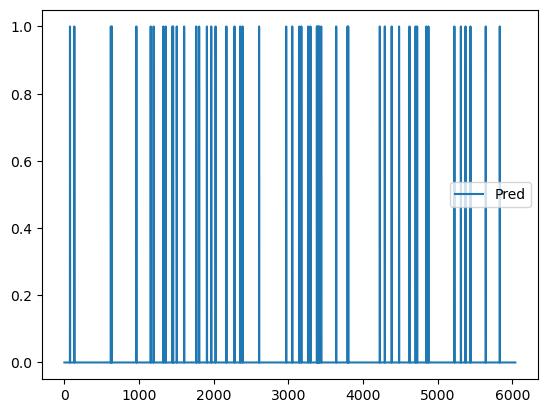

In [19]:
pred_CAT = clf_CAT.predict(test_df)
plt.plot(np.array(pred_CAT), label="Pred")
plt.legend()
plt.show()